In [1]:
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline

from lsst_efd_client import EfdClient, resample, merge_packed_time_series, rendezvous_dataframes
from lsst.ts.idl.enums import MTM1M3

from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# Functions 

In [9]:
def combine_peaks_accross_actuators(peak_frame, window=4):
    # takes a set of identified peaks in different actuators and associates nearby 
    # ones default window is 4 seconds, 
    # returns 1 peak per window and the max height of peaks in that window as well as the number of 
    # actuators that saw that peak, only returns peaks seen with more than 3 actuators.
    super_heights =[]
    super_times = []
    super_counts = [] 
    super_actuators= []
    for peak in peak_frame["times"].values:
        sel = (abs(peak_frame["times"]-peak) < window)
        subframe=peak_frame[sel]
        count=len(np.unique(subframe["actuators"]))
        if count > 3:
            max_height=subframe["heights"].max()
            super_counts.append(count)
            super_heights.append(max_height)
            super_times.append(subframe["times"][subframe["heights"]==max_height].values)
            super_actuators.append(subframe["actuators"][subframe["heights"]==max_height].values)
    super_times = np.concatenate(super_times)
    super_actuators = np.concatenate(super_actuators)
    super_heights=np.array(super_heights)
    super_counts=np.array(super_counts)
    super_times, super_inds=np.unique(super_times, return_index=True)
    super_heights=super_heights[super_inds]
    super_actuators=super_actuators[super_inds]
    super_counts=super_counts[super_inds]
    return pd.DataFrame({"times":super_times,"heights":super_heights,"counts":super_counts, "actuators":super_actuators})

def add_timestamp(data):
    # add correct timestamp column in utc
    if "snd_timestamp_utc" not in data.columns:
        data["snd_timestamp_utc"]=Time(data["private_sndStamp"], format = "unix_tai").unix
    return data

# Query
Need the elevation telemetry and hardpoint measured forces

In [10]:
# Get EFD client

summit_client = False

if summit_client:
    client = EfdClient('summit_efd')
else:
    client = EfdClient("usdf_efd")

In [11]:
start = Time("2023-06-15T21:00:00", scale='utc')
window = TimeDelta(9*60*60, format = 'sec')
end = start + window

In [12]:
el = await client.select_time_series('lsst.sal.MTMount.elevation', \
                                        ['*'],  start, end)
el=add_timestamp(el)

hpmf = await client.select_time_series('lsst.sal.MTM1M3.hardpointActuatorData', \
                                        ['private_sndStamp',
                                         'measuredForce0', 
                                         'measuredForce1', 
                                         'measuredForce2', 
                                         'measuredForce3',
                                         'measuredForce4', 
                                         'measuredForce5'],  start, end)
hpmf = add_timestamp(hpmf)

# Identification of peaks
results will be in overall_frame that has the columns ['times', 'heights', 'counts', 'actuators', 'slew_state']

In [13]:
# given hp data iterate over all and create a dict with identified peaks as well as their height
rolling_std_window = 100  # 100 is ~ 2 second window
association_window_1 = 2 # window in seconds to combine peaks in same actuator
association_window_2 = 4 # window in seconds to combine peaks accross actuators
slew_speed_min = 0.01 # used for identifiying when we are slewing

peak_dict={}
peak_frame=pd.DataFrame({"times":[],"heights":[],"actuators":[]})


for i in range(6):
    # this loop identifies rolling std peaks in the measured force
    rolling_std_val=hpmf[f"measuredForce{i}"].rolling(rolling_std_window).std() # 100 is ~ 2 second window
    peak_indicies=find_peaks(rolling_std_val, height=50)[0] 
    
    # keep time and height of peaks
    peak_dict[f"hp_{i}_peak_times"]=hpmf["snd_timestamp_utc"][peak_indicies].values
    peak_dict[f"hp_{i}_peak_heights"]= rolling_std_val[peak_indicies].values

    # for each peak combine by looking at all peaks within 
    # a window and keeping the one with the largest height then np.unique that 
    super_heights=[]
    super_times=[]
    for j,peak in enumerate(peak_dict[f"hp_{i}_peak_times"]):
        sel_peaks=(abs(peak_dict[f"hp_{i}_peak_times"]-peak) < association_window_1)
        max_height=np.max(peak_dict[f"hp_{i}_peak_heights"][sel_peaks])
        max_time=peak_dict[f"hp_{i}_peak_times"][sel_peaks][np.where(peak_dict[f"hp_{i}_peak_heights"][sel_peaks]==max_height)]
        max_index=np.where(peak_dict[f"hp_{i}_peak_times"]==max_time)[0]
        super_times.append(peak_dict[f"hp_{i}_peak_times"][max_index])
        super_heights.append(peak_dict[f"hp_{i}_peak_heights"][max_index])
    peak_dict[f"hp_{i}_peak_times"] = np.unique(super_times)
    peak_dict[f"hp_{i}_peak_heights"] = np.unique(super_heights)
    peak_frame=pd.concat([peak_frame,pd.DataFrame({"times":peak_dict[f"hp_{i}_peak_times"],
                                                   "heights":peak_dict[f"hp_{i}_peak_heights"],
                                                   "actuators":i})])
peak_frame=peak_frame.sort_values("times")

# next we want to combine peaks across actuators
overall_frame=combine_peaks_accross_actuators(peak_frame, window=association_window_2)

#identify when we are slewing
overall_frame["slew_state"]=False
slew_speed=interp1d(el["snd_timestamp_utc"],abs(el["actualVelocity"].rolling(10).mean()))
sel=(slew_speed(overall_frame["times"]) > slew_speed_min)
overall_frame.loc[sel,"slew_state"]=True

Text(0, 0.5, 'measured force')

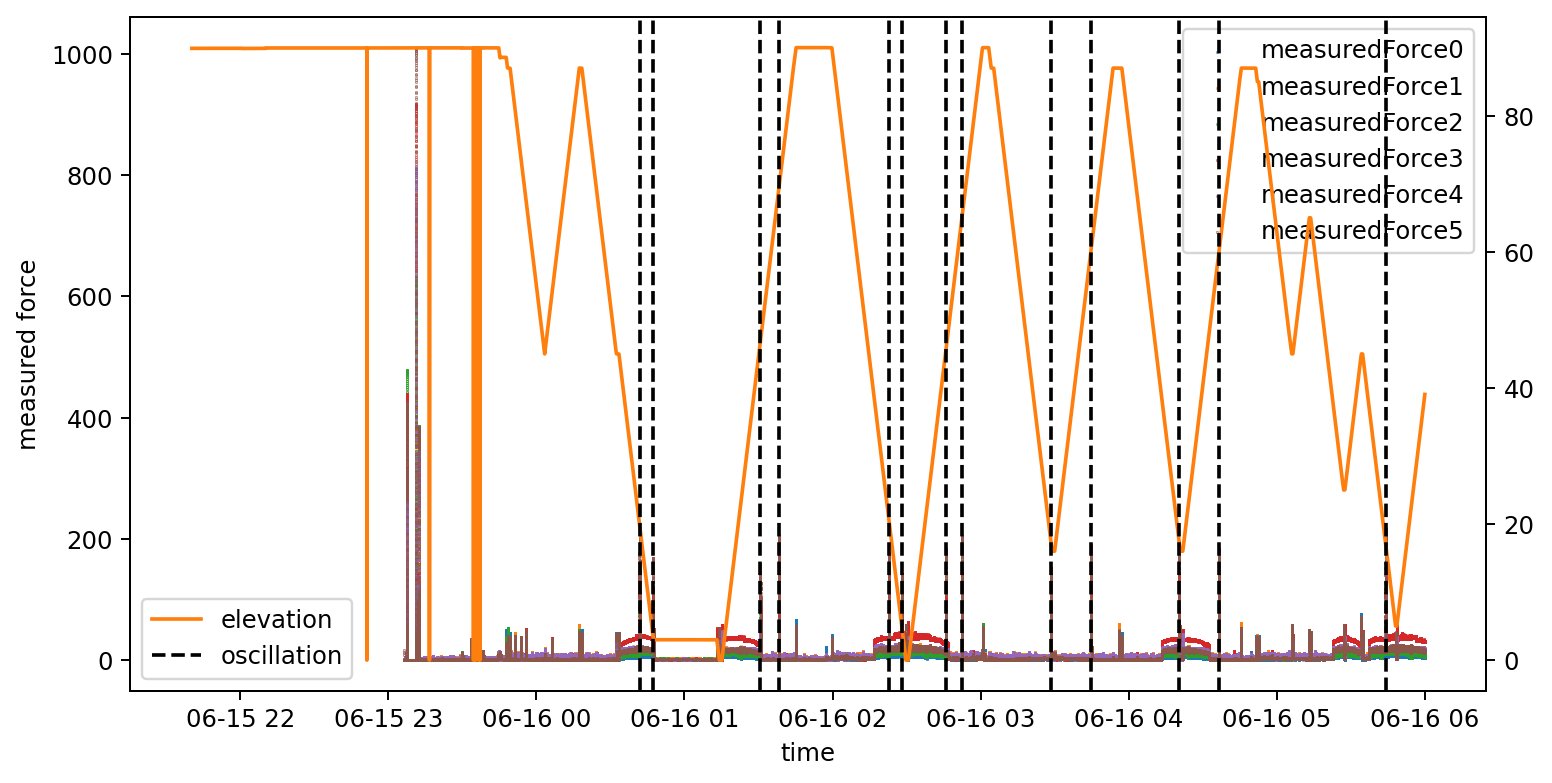

In [15]:
fig, ax=plt.subplots(1,dpi=175, figsize=(10,5))
ax2=ax.twinx()
for i in np.arange(0,6):
    ax.scatter(Time(hpmf["snd_timestamp_utc"],format="unix").datetime, 
               hpmf[f"measuredForce{i}"].rolling(100).std(), s=0.05, zorder=10, label=f"measuredForce{i}")
l3=ax2.plot(Time(el["snd_timestamp_utc"],format="unix").datetime , el["actualPosition"], color="tab:orange", zorder=1, label="elevation")

for k, j in enumerate(overall_frame["times"][overall_frame["slew_state"] == True]):
    l2=plt.axvline(Time(j, format="unix").datetime, ls="dashed", c="k", label="oscillation time")
    if k==0:
        ax2.legend()
# for j in peak_dict["slew_peaks"]:
#     plt.axvline(Time(j, format="unix").datetime, ls="dashed", c="r")
# #ax2.step(el_axis_motion_state.index, el_axis_motion_state["state"], where="post", ls="dashed", c="k")
#ax.set_yscale('log')
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("measured force")

Text(0, 0.5, 'TMA Elevation')

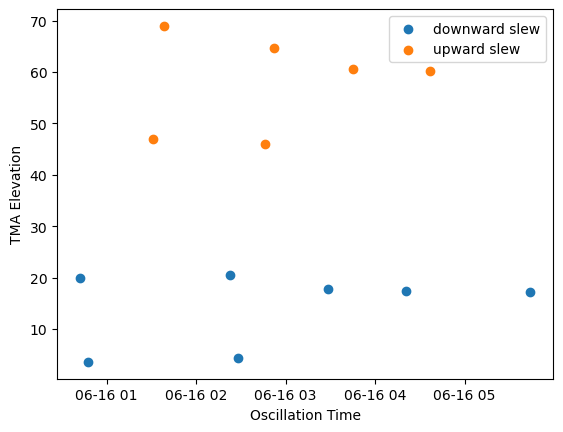

In [19]:
x=overall_frame["times"][overall_frame["slew_state"] == True]
slew_pos=interp1d(el["snd_timestamp_utc"],(el["actualPosition"].rolling(10).mean()))
y=slew_pos(x)
slew_vel=interp1d(el["snd_timestamp_utc"],(el["actualVelocity"].rolling(10).mean()))
z=slew_vel(x)

plt.scatter(Time(x[z <=0], format="unix").datetime,y[z <=0], label="downward slew")
plt.scatter(Time(x[z > 0], format="unix").datetime,y[z > 0], label="upward slew")
plt.legend()
plt.xlabel("Oscillation Time")
plt.ylabel("TMA Elevation")

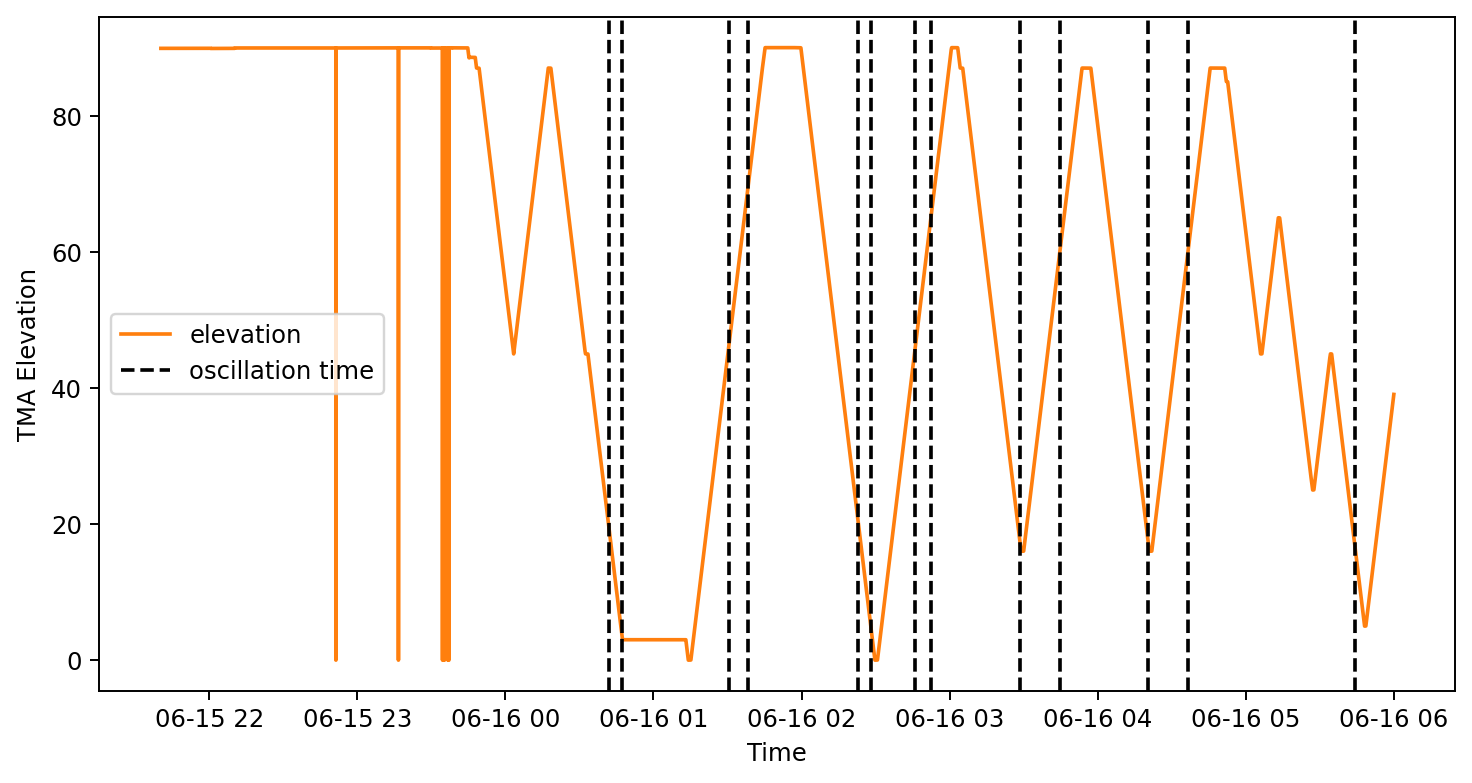

In [21]:
fig, ax=plt.subplots(1,dpi=175, figsize=(10,5))
l3=ax.plot(Time(el["snd_timestamp_utc"],format="unix").datetime , el["actualPosition"], color="tab:orange", zorder=1, label="elevation")
plt.ylabel("TMA Elevation")
plt.xlabel("Time")
for k, j in enumerate(overall_frame["times"][overall_frame["slew_state"] == True]):
    l2=plt.axvline(Time(j, format="unix").datetime, ls="dashed", c="k", label="oscillation time")
    if k==0:
        ax.legend()

In [ ]:
fig, ax=plt.subplots(1,dpi=175, figsize=(10,5))
ax2=ax.twinx()
ax.scatter(Time(el["snd_timestamp_utc"],format="unix").datetime , el["actualVelocity"], color="tab:orange", s=0.08, zorder=1)

ax2.scatter(Time(el["snd_timestamp_utc"],format="unix").datetime , el["actualPosition"], color="tab:blue", s=0.08, zorder=1)
for j in overall_frame["times"][overall_frame["slew_state"] ==True ]:
    ax.axvline(Time(j, format="unix").datetime, ls="dashed", c="k")